<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=25% ALIGN="right">
</figure>

<p><div> 
<br><b>Monitoring of Structural Health and Geohazards</b>
<br><b>CEGM2008</b>
<br> Faculty of Civil Engineering and Geosciences - Delft University of Technology 
<br><b>Responsible instructor:</b>
<br><i>- Eliz-Mari Lourens</i>
</div>
<br><b>Notebooks created by teaching assistants:</b>
<br><i>- Siemen Algra</i>
<br><i>- Heisuke Miyoshi</i>
</div>


# 3.2 System identification: Frequency domain decomposition
    
In this notebook you will identify the dynamic properties of the cantilever beam from artificial vibration data. The notebook starts by first generating the artificial data, and then continues with the identification. The method used to perform the operational modal analysis is frequency domain decomposition. 

NOTE 1: Make sure you have numpy, matplotlib, scipy, and plotly installed in your environment. If you receive an error indicating that a package (module) is not found, open your command prompt (anaconda prompt if using anaconda) and type either "pip install (packagename)" or "conda install (packagename)".  

NOTE 2: Make sure you have the file for constructing the FE model of the cantilever beam (model.py) stored in the same location as this notebook.

In [158]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import plotly.graph_objects as go
import plotly.express as px

## Set up the beam model

Eigenfrequencies [Hz]:

[  21.0222448   131.74442861  368.89347935  722.91731257 1195.16190219
 1785.73125816 2494.98951148 3323.53528584 4272.28557265 5342.55488575]


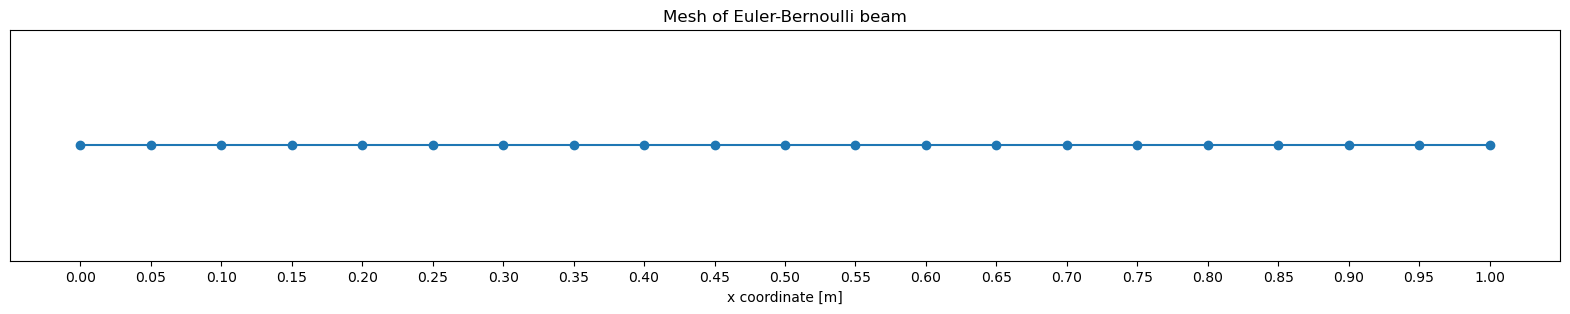

In [159]:
import model

M, K, Phi_model, Omega_model, n_elements, n_nodes, n_dofs = model.get_M_and_K_matrix()

In [160]:
# Construct the damping matrix assuming modal damping
xi = 0.05  # Constant modal damping ratio assumed

# Create damping matrix
Cstar = np.diag(2*Omega_model*xi)
C_matrix = M @ Phi_model @ Cstar @ Phi_model.T @ M

## Define the excitation

In [161]:
# Construct a boolean selection vector for specifying the force location (=vertical DOF of last node)
S_force = np.zeros((n_dofs,1))
S_force[-2] = 1 # Apply force at the last node on first DOF

In [162]:
# Defining sampling parameters
dt = 1e-4
N = int(2**16)
t = np.arange(0, N*dt, dt)
F = 1/dt
df = F/N
freq = np.arange(0, F/2, df)    # only the positive frequencies

In [163]:
# Broadband excitation (white noise, with zero padding)
pn = np.zeros((N,))
pn[50:] = 100 * np.random.randn(N-50)

# Harmonic superposed force
ph = np.zeros((N,))
ph[50:] = 100 * np.sin(100*2*np.pi*t[:N-50])

# Total force
p = pn + ph

# Transform to frequency domain
p_omega = fft(p, axis=0)

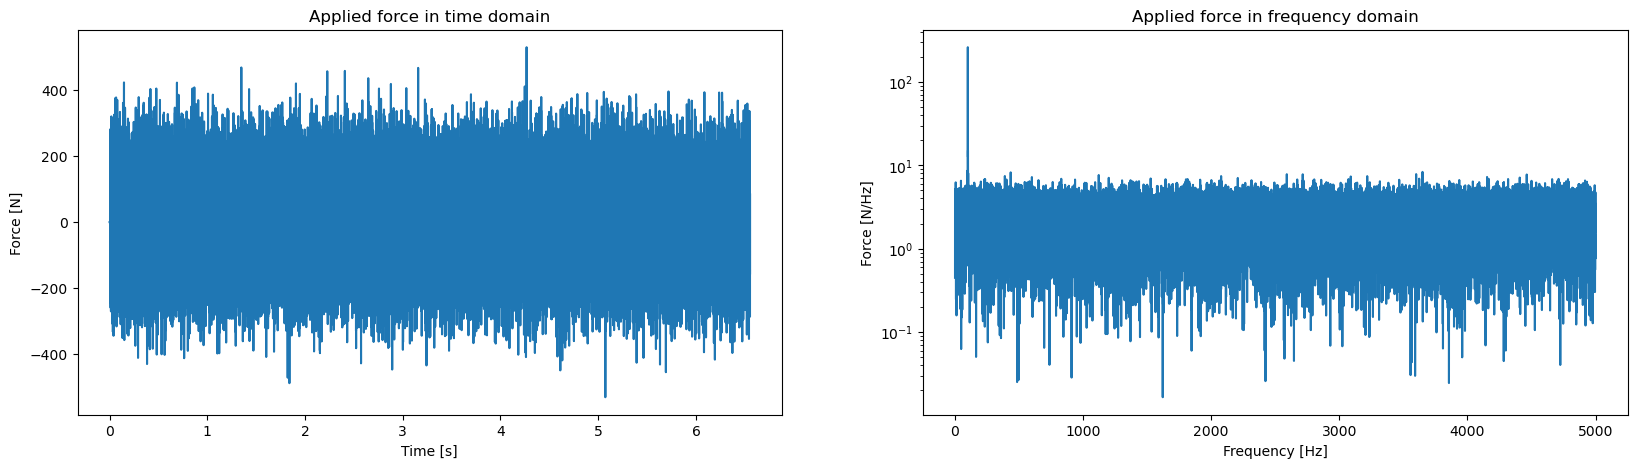

In [164]:
# Visualize the force arrays in time 
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(t, p, label='p')
ax[0].set_title('Applied force in time domain')
ax[0].set_ylabel('Force [N]')
ax[0].set_xlabel('Time [s]')

ax[1].plot(freq, np.abs(p_omega[0:N//2])*dt)
ax[1].set_title('Applied force in frequency domain')
ax[1].set_ylabel('Force [N/Hz]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_yscale('log')


## Generate the artificial data by calculating the response of the beam to the defined forcing

In [165]:
# Solve part
N_counter = int(N/2)
u_omega = np.zeros((n_dofs, N_counter), dtype=np.complex128) #displacement in frequency domain
a_omega = np.zeros((n_dofs, N_counter), dtype=np.complex128) #acceleration in frequency domain

for ind in range(N_counter):
    omega = freq[ind] * 2 * np.pi
    # Construct the transfer function matrix H [nDOF x nDOF]
    H = np.linalg.inv(-omega**2 * M + 1j * omega * C_matrix + K)
    
    # Construct the force vector, adding force to the correct DOFs
    P_omega = p_omega[ind] * S_force
    
    # Solve for the displacement vector and acceleration vector in the frequency domain
    u_omega[:, ind] = np.reshape(H @ P_omega, (n_dofs,))
    a_omega[:, ind] = -omega**2 * u_omega[:, ind]
    
# Extend the frequency spectra to include also the negative frequencies (conjugation property)
u_omega = np.hstack((u_omega, np.zeros((n_dofs, 1), dtype=complex), np.conj(u_omega[:, 1:][:, ::-1])))
a_omega = np.hstack((a_omega, np.zeros((n_dofs, 1), dtype=complex), np.conj(a_omega[:, 1:][:, ::-1])))

In [166]:
# Applying inverse FFT to get the displacement/acceleration in time domain
u = np.fft.ifft(u_omega, axis=1)
a = np.fft.ifft(a_omega, axis=1)

# Transposing the arrays for plotting later
u = u.T
u_omega = u_omega.T
a = a.T
a_omega = a_omega.T

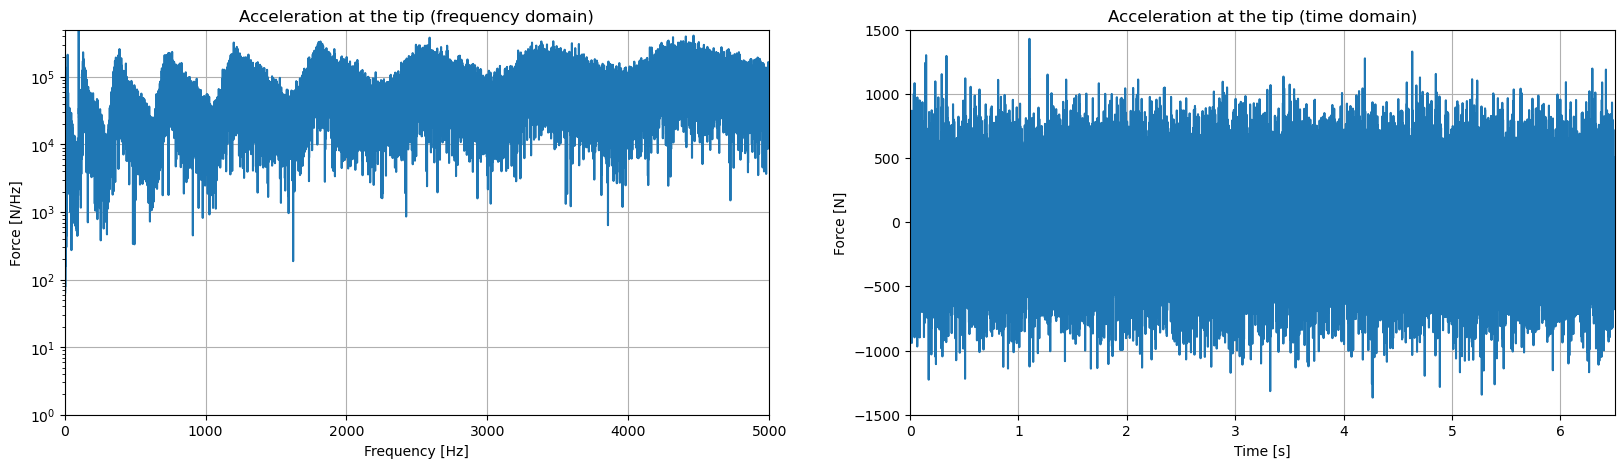

In [167]:
# Plot the acceleration of the last node in the time and frequency domain
acc_omega_tip = a_omega[:, -2]
acc_tip = a[:, -2].real

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(freq, np.abs(acc_omega_tip[0:N//2]))
ax[0].set_title('Acceleration at the tip (frequency domain)')
ax[0].set_ylabel('Force [N/Hz]')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_yscale('log')
ax[0].set_xlim(0, F/2)
ax[0].set_ylim(1e0, 5e5)
ax[0].grid()

# Plot the displacement in the time domain of the last node
ax[1].plot(t, acc_tip)
ax[1].set_title('Acceleration at the tip (time domain)')
ax[1].set_ylabel('Force [N]')
ax[1].set_xlabel('Time [s]')
ax[1].set_xlim(0, 6.5)
ax[1].set_ylim(-1500, 1500)
ax[1].grid()

In [168]:
# Calculate the modal transfer functions
modal_d = np.zeros((5, N_counter), dtype=np.complex128) # transfer function for displacement
modal_a = np.zeros((5, N_counter), dtype=np.complex128) # transfer function for acceleration

Omega_5 = Omega_model[:5]

for ind in range(N_counter):
    omega = freq[ind] * 2 * np.pi
    # Displacement
    modal_d[:, ind] = 1/(-omega**2 + 2j*omega*Omega_5*xi + Omega_5**2)
    # Acceleration
    modal_a[:,ind] = -omega**2 * modal_d[:, ind]

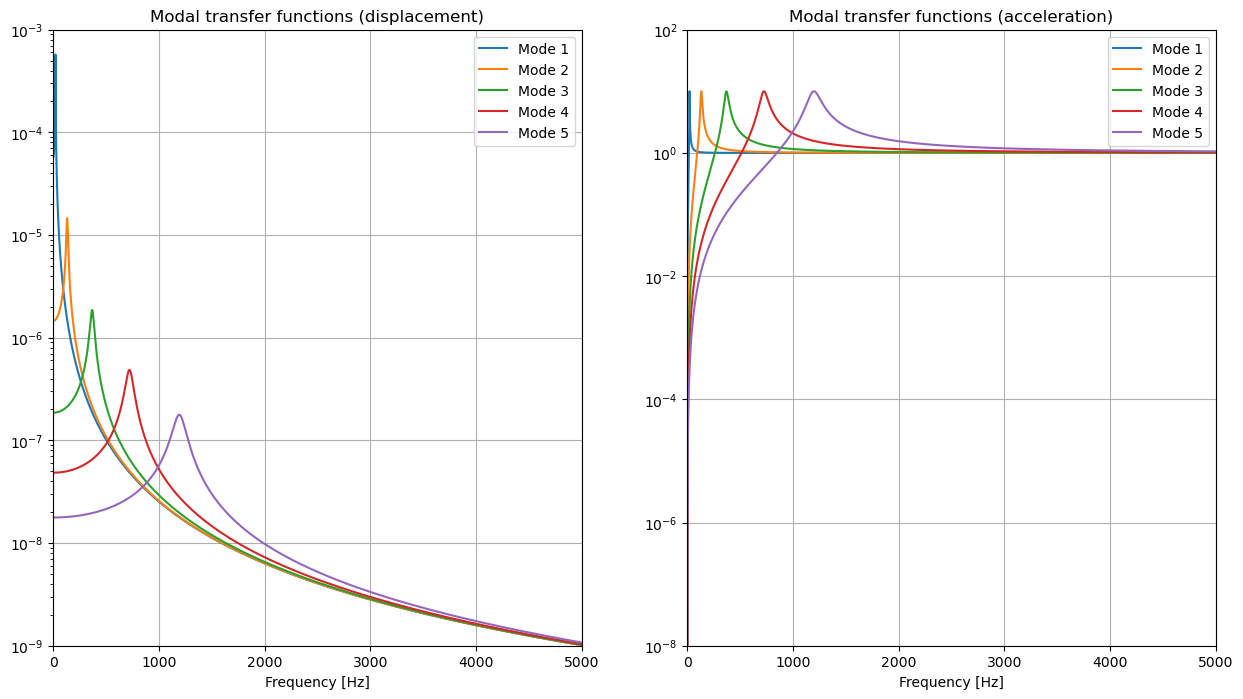

In [169]:
# Plot the modal transfer functions for displacement and acceleration
fig, ax =  plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,8))
ax[0].set_title('Modal transfer functions (displacement)')
ax[1].set_title('Modal transfer functions (acceleration)')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylim(1e-9, 1e-3)
ax[1].set_ylim(1e-8, 1e2)
ax[0].set_xlim(0, 5000)
ax[0].set_xlabel('Frequency [Hz]')
ax[1].set_xlabel('Frequency [Hz]')
ax[0].grid()
ax[1].grid()

# Plotting part
for i in range(5):
    ax[0].plot(freq, np.abs(modal_d[i]), label="Mode {}".format(i+1))
    ax[1].plot(freq, np.abs(modal_a[i]), label="Mode {}".format(i+1))

ax[0].legend()
ax[1].legend();

## System identification: frequency domain decomposition

### Construct the artificial data matrix

In [170]:
n_d = int(10)    # number of measurements

# Specify where the measurements are taken:
# Vertical DOF of nodes 2, 4, 6, 8, 10, 12, 14, 16, 18, 20
data_loc = np.array([4*i+2 for i in range(n_d)])
S_data = np.zeros((n_d, n_dofs))
for i in range(n_d):
    S_data[i, data_loc[i]] = 1
    
# Retrieve the acceleration data from the response matrices calculated earlier
data = a[:, data_loc]

# FFT of the data--> frequency domain
data_omega = fft(data, axis=1)


In [171]:
# Add noise to the calculated data
nl = 0.03 # noise level (as a fraction of the standard deviation of the data)

# Get the standard deviation of each measurement
std = np.std(data, axis=0) 

# Add the noise
data_n = data + nl * std.T * np.random.randn(N, n_d)

### Segment the data 
(for the approximation of the output spectral density matrix)

In [172]:
# Split the data into 'n_seg' segments and perform the FFT for each segment
n_seg = 3
# New sampling parameters
N_seg = N / n_seg
N_seg_counter = int(N_seg/2) # again only the positive frequencies
t_seg = np.arange(0, N_seg, dt)
F = 1 / dt
df_seg = F/N_seg
freq_seg = np.arange(0, F/2, df_seg)

# Split the data
data_split = np.array_split(data_n, n_seg)
# Store all segments in a list
data_seg = [data_split[i] for i in range(n_seg)]
data_seg_fft = [fft(data_seg[i], axis=0) for i in range(n_seg)]
print(data_seg_fft[0].shape) # Check the shape of each matrix in the list

(21846, 10)


### Approximate the output spectral density matrix and decompose it using a SVD

In [173]:
# Initialize matrices for storing the singular values en left/right singular vectors at each frequency
U_omega = np.zeros((N_seg_counter, n_d, n_d), dtype=np.complex128)
V_omega = np.zeros((N_seg_counter, n_d, n_d), dtype=np.complex128)
S_omega = np.zeros((n_d, N_seg_counter))

# Approximate the output spectral density matrix (Sdd) and decompose
for i in range(N_seg_counter):
     Sdd = np.zeros((n_d, n_d), dtype=np.complex128)
     for seg in data_seg_fft: # Looping over the segments to calculate Sdd as an average
          arr_seg = np.reshape(seg[i, :], (n_d, 1)) # reshape the applicable row in the list to a 10x1 array
          Sdd += arr_seg @ np.conj(arr_seg.T)  # (n_d, n_d)
     
     U, S, V = np.linalg.svd(Sdd) # Perform the SVD
     U_omega[i] = U
     V_omega[i] = V
     S_omega[:, i] = S

In [174]:
# Plot the singular values
fig = go.Figure()
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[0, :], name='Singular value 1', line=dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[1, :], name='Singular value 2', line=dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[2, :], name='Singular value 3', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[3, :], name='Singular value 4', line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[4, :], name='Singular value 5', line=dict(color='purple', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[5, :], name='Singular value 6', line=dict(color='brown', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[6, :], name='Singular value 7', line=dict(color='pink', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[7, :], name='Singular value 8', line=dict(color='grey', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[8, :], name='Singular value 9', line=dict(color='yellow', width=2)))
fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[9, :], name='Singular value 10', line=dict(color='black', width=2)))

fig.update_yaxes(type="log")

fig.update_layout(
    xaxis=dict(title="Frequency [Hz]"),
    yaxis=dict(title="Singular values"),
    showlegend=False)

fig.show()


### Extract the eigenfrequencies and eigenvectors

In [175]:
# Select eigenfrequencies from the figure above
freq1 = 20.6
freq2 = 127
freq3 = 369
freq4 = 731
freq5 = 1207

# Find the indices of the eigenfrequencies and store them in a list
index_1 = np.where(freq_seg > freq1)[0][0]
index_2 = np.where(freq_seg > freq2)[0][0]
index_3 = np.where(freq_seg > freq3)[0][0]
index_4 = np.where(freq_seg > freq4)[0][0]
index_5 = np.where(freq_seg > freq5)[0][0]
indices = [index_1, index_2, index_3, index_4, index_5]

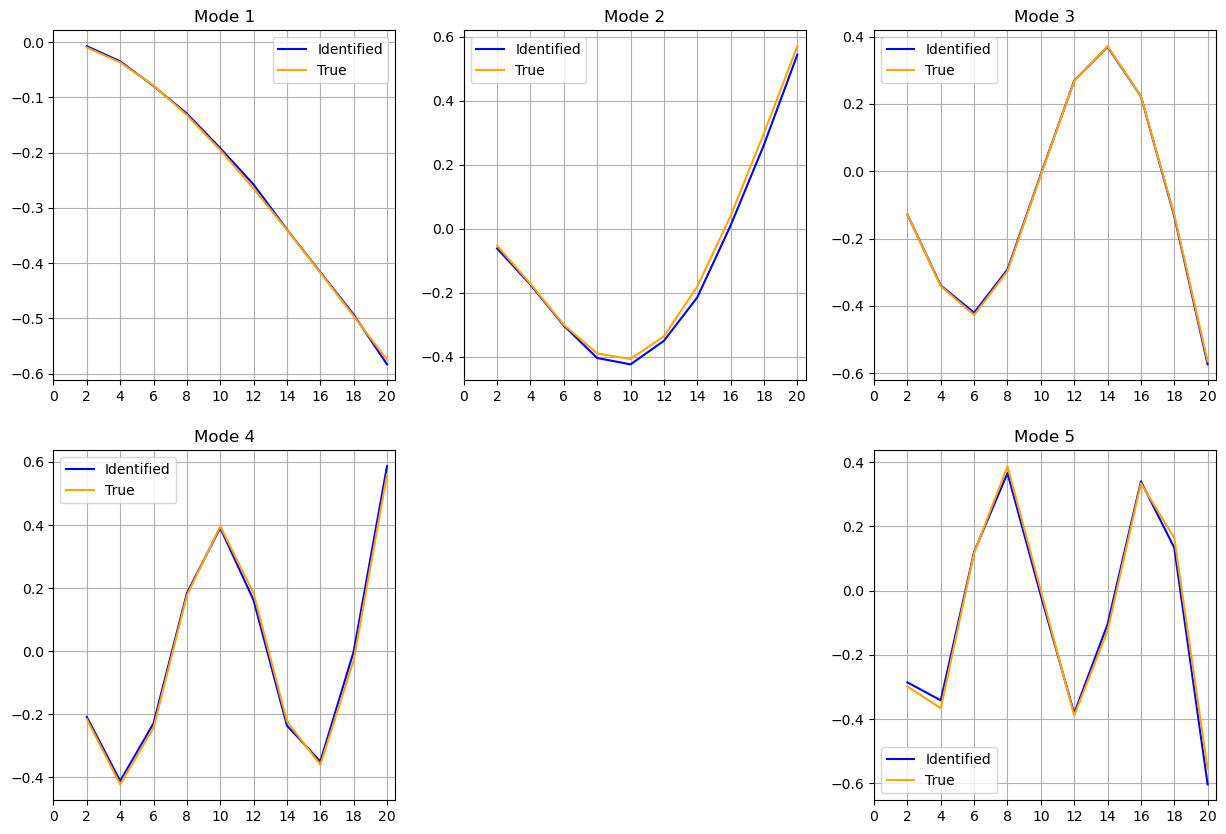

In [176]:
# Create a vector to specify the DOFs where we have identified the values of the eigenvectors (i.e. the measured DOFs)
ind_d = np.where(np.sum(S_data, axis=0) > 0)[0]
# Initialize a vector to store the identified eigenvectors
Phi_id = np.zeros((ind_d.shape[0], 5))
# Phi_m contains the first 5 true eigenvectors
Phi_m = Phi_model[ind_d, :5]

# Plot the identified and true eigenvectors
fig, ax = plt.subplots(2, 3, figsize=(15,10))
ax[1][1].remove()
axes = [ax[0][0], ax[0][1], ax[0][2], ax[1][0], ax[1][2]]

for ind, ax in enumerate(axes):
    # Extract the eigenvectors from the stored matrix containing all left singular vectors (per frequency)
    Phi_id[:, ind] = U_omega[indices[ind], :, 0].real
    # Normalize the eigenvectors
    Phi_m[:, ind] = Phi_m[:, ind] / np.linalg.norm(Phi_m[:, ind])
    Phi_id[:, ind] = Phi_id[:, ind] / np.linalg.norm(Phi_id[:, ind])
    
    # Match the sign of the eigenvectors
    if np.sign(np.real(U_omega[indices[ind], 1, 0])) == np.sign(Phi_m[1, ind]):
        axes[ind].plot(data_loc/2 + 1, Phi_id[:, ind], label='Identified', color='blue')
        axes[ind].plot(data_loc/2 + 1, Phi_m[:, ind], label='True', color='orange')
        axes[ind].legend()

    else:
        axes[ind].plot(data_loc/2 + 1, Phi_id[:, ind], label='Identified', color='blue')
        axes[ind].plot(data_loc/2 + 1, -Phi_m[:, ind], label='True', color='orange')
        axes[ind].legend()
    
    axes[ind].set_title(f'Mode {ind+1}')
    axes[ind].set_xlim(1, 20.5)
    axes[ind].set_xticks(np.arange(0, 22, 2))
    axes[ind].grid()

plt.show()

### MAC matrix calculation

In [177]:
# Calculate and plot the global MAC matrix
MAC = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        MAC[i, j] = (np.abs(Phi_id[:, i].conj().T @ Phi_id[:, j]))**2 / ((Phi_id[:, i].conj().T @ Phi_id[:, i]) * (Phi_id[:, j].conj().T @ Phi_id[:, j]))

# Plot the MAC matrix: Check if the off-diagonal elements are close to zero
fig = px.imshow(MAC)
fig.show()

### Save the results to use later in the model updating

In [178]:
# Export the identified eigenfrequencies and eigenvectors
omega_id = [freq1, freq2, freq3, freq4, freq5]

# Define the path to the output folder
path_output = ""

# Exporting
np.savetxt(path_output + "omega_id.txt", omega_id)
np.savetxt(path_output + "Phi_id.txt", Phi_id)
np.savetxt(path_output + "ind_id.txt", ind_d, fmt='%d')